<a href="https://colab.research.google.com/github/nnshoshin/projects/blob/main/praktikum_texts_shoshin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Проект для «Викишоп»

Обучите модель классифицировать комментарии под карточками товаров интернет-магазина на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

## Подготовка

Подгрузим необходимые библиотеки:

In [ ]:
import numpy as np
import pandas as pd
from tqdm import notebook 
from time import time
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split 
from nltk.stem import WordNetLemmatizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import re 
import nltk
from nltk.corpus import stopwords
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import TfidfVectorizer 
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import precision_recall_curve
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

In [ ]:
pip install catboost

In [ ]:
from catboost import CatBoostClassifier

Загрузим исходные данные и взглянем на них:

In [ ]:
df=pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv')

In [ ]:
df

,text,toxic
0,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0
1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0
2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0
3,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport """,0
4,"You, sir, are my hero. Any chance you remember what page that's on?",0
...,...,...
159566,""":::::And for the second time of asking, when your view completely contradicts the coverage in reliable sources, why should anyone care what you feel? You can't even give a consistent argument - is the opening only supposed to mention significant aspects, or the """"most significant"""" ones? \n\n""",0
159567,You should be ashamed of yourself \n\nThat is a horrible thing you put on my talk page. 128.61.19.93,0
159568,"Spitzer \n\nUmm, theres no actual article for prostitution ring. - Crunch Captain.",0
159569,And it looks like it was actually you who put on the speedy to have the first version deleted now that I look at it.,0


Текст необходимо предобратать. Лемматизировать и очистить от знаков препинания и служебных символов:

In [ ]:
df['text'] = df['text'].apply(lambda x: re.sub(r'[^a-zA-Z ]' , ' ', x) )

  
lemmatizer = WordNetLemmatizer()
df['text'] = df['text'].apply(lambda x: ' '.join([lemmatizer.lemmatize(w) for w in x.split(" ")]))



Проверим полученный результат:

In [ ]:
df

,text,toxic
0,Explanation Why the edits made under my username Hardcore Metallica Fan were reverted They weren t vandalism just closure on some GAs after I voted at New York Dolls FAC And please don t remove the template from the talk page since I m retired now,0
1,D aww He match this background colour I m seemingly stuck with Thanks talk January UTC,0
2,Hey man I m really not trying to edit war It s just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page He seems to care more about the formatting than the actual info,0
3,More I can t make any real suggestion on improvement I wondered if the section statistic should be later on or a subsection of type of accident I think the reference may need tidying so that they are all in the exact same format ie date format etc I can do that later on if no one else doe first if you have any preference for formatting style on reference or want to do it yourself please let me know There appears to be a backlog on article for review so I guess there may be a delay until a reviewer turn up It s listed in the relevant form eg Wikipedia Good article nomination Transport,0
4,You sir are my hero Any chance you remember what page that s on,0
...,...,...
159566,And for the second time of asking when your view completely contradicts the coverage in reliable source why should anyone care what you feel You can t even give a consistent argument is the opening only supposed to mention significant aspect or the most significant one,0
159567,You should be ashamed of yourself That is a horrible thing you put on my talk page,0
159568,Spitzer Umm there no actual article for prostitution ring Crunch Captain,0
159569,And it look like it wa actually you who put on the speedy to have the first version deleted now that I look at it,0


Готово. Теперь взглянем на целевой признак:

In [ ]:
df.describe()

,toxic
count,159571.000000
mean,0.101679
std,0.302226
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


Наблюдается дисбаланс классов, токсичных комментариев у нас всего около 10%.

In [ ]:
df.isna().sum()

text     0
toxic    0
dtype: int64

Пропусков в данных нет.

In [ ]:
df.duplicated().sum()

214

Имеется 214 дубликатов, удалим их:

In [ ]:
df.drop_duplicates(inplace=True)

In [ ]:
df.duplicated().sum()

0

Готово.
Разделим данные на тренировочную, валидационную и тестовую выборки:

In [ ]:
features_train, features_test, target_train, target_test = train_test_split(df['text'], df['toxic'], test_size=0.2)
features_train, features_valid, target_train, target_valid = train_test_split(df['text'], df['toxic'], test_size=0.25)
print(features_train.shape, features_valid.shape, features_test.shape, target_train.shape,target_valid.shape, target_test.shape )


(119517,) (39840,) (31872,) (119517,) (39840,) (31872,)


Проведем векторизацию текста с помощью класса TfidfVectorizer(), который учитывает важность каждого слова путем оценивания частоты их употребления во всем корпусе. С помощью параметра stop_words передадим список не несущих смысла слов, которые не следует учитывать в процессе векторизации. 

In [ ]:
stopwords = set(stopwords.words('english'))
count_tf_idf = TfidfVectorizer(stop_words=stopwords)

tf_idf_train = count_tf_idf.fit_transform(features_train)
tf_idf_valid = count_tf_idf.transform(features_valid)
tf_idf_test = count_tf_idf.transform(features_test)

Далее в закомментированной ячейке мои манипуляции с BertTokenizer. Bert показала себя хуже, поэтому в процессе работы я откинул эту модель. 

In [ ]:
# pip install transformers
# pip install torchvision 
# import torch
# import transformers
# torch.cuda.is_available() 
# tokenizer = transformers.BertTokenizer.from_pretrained("bert-base-cased")

# vector=[]
# for i in df['text']:
#     vector.append(tokenizer.encode(i,  add_special_tokens=True, truncation=True))
# max_len=0    
# for i in vector:
#     if len(i)>max_len:
#         max_len=len(i)

# padded = np.array([i + [0]*(max_len - len(i)) for i in vector])
# attention_mask = np.where(padded != 0, 1, 0)
# #model = transformers.BertModel.from_pretrained("bert-base-cased")

# model     = model.to('cuda')
# batch_size = 100
# embeddings = []
# for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
#         batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)])
#         batch = batch.to('cuda:0')
#         attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])
#         attention_mask_batch = attention_mask_batch.to('cuda:0')
#         with torch.no_grad():
#             batch_embeddings = model(batch, attention_mask=attention_mask_batch)

#         embeddings.append(batch_embeddings[0][:,0,:].cpu().numpy())
# features = []
# features = np.concatenate(embeddings)
# df_features_distilled = pd.DataFrame(data=features)
# df_features_distilled.to_csv("./df_features_distilled.csv", sep=',',index=False)
# df_features = pd.DataFrame(data=features)
# df_features.to_csv("./df_features_v1.csv", sep=',',index=False)
# df_features = pd.read_csv('/content/df_features_v1.csv', sep=',')
# df_features 
# from google.colab import  drive
# drive.mount('/drive')
# df_features.to_csv('/drive/My Drive/df_features_v1.csv')


Предоработка проведена, данные готовы к обучению. 

## Обучение

Сразу введём функцию, с помощью которой будем определять порог классификации. 

In [ ]:
def thr(y_pred_proba, target_valid):
  best_thr=0
  best_f1_score=0
  for threshold in np.arange(0.2, 0.9, 0.0001):
            y_pred = y_pred_proba[:, 1] > threshold
            f1score = f1_score(target_valid,y_pred )
            if f1score > best_f1_score:
              best_f1_score=f1score
              best_thr=threshold
  return best_thr, best_f1_score

Обучим модель логистической регрессии с параметром, учитывающим дисбаланс классов:

In [ ]:
modellogreg = LogisticRegression(class_weight='balanced') 
modellogreg.fit(tf_idf_train, target_train) 
y_pred_proba_logreg = modellogreg.predict_proba(tf_idf_valid)
thr_logreg, f1_logreg  = thr(y_pred_proba_logreg, target_valid)
print(thr_logreg, f1_logreg)


0.6413999999999513 0.7746513944223107


Обучение и предсказание заняло всего лишь 1 минуту, а F1 мера на тестовой выборке составила 0.77, что удоалетворяет условию. Проверим другие модели. 

Подберем параметры для случайного леса:

In [ ]:
param_grid = {'n_estimators': np.arange(2, 16), 
 'max_depth': np.arange(10, 50)}


modelforest = RandomForestClassifier(random_state=12345,  class_weight='balanced')

search_forest = RandomizedSearchCV(modelforest, param_grid, scoring='f1')
search_forest.fit(tf_idf_train, target_train)

print('Гиперпараметры:', search_forest.best_params_)

Обучим случайный лес на полученных параметрах:

In [ ]:
modelforest = RandomForestClassifier(random_state=12345,  class_weight='balanced', n_estimators=15 , max_depth=46 )
modelforest.fit(tf_idf_train, target_train)
y_pred_proba_forest = modelforest.predict_proba(tf_idf_valid)
thr_forest, f1_forest  = thr(y_pred_proba_forest, target_valid)
print(thr_forest, f1_forest)


0.5580999999999605 0.6065287088312445


Не принимаем, F1 меньше необходимого. Проверим дерево решений:

In [ ]:
param_grid = {'max_depth': np.arange(10, 50)}


modeltree = DecisionTreeClassifier(random_state=12345,  class_weight='balanced')

search_tree = RandomizedSearchCV(modeltree, param_grid, scoring='f1')
search_tree.fit(tf_idf_train, target_train)
print('Гиперпараметры:', search_tree.best_params_)


Гиперпараметры: {'max_depth': 48}


In [ ]:
modeltree = DecisionTreeClassifier(random_state=12345,  class_weight='balanced', max_depth=48)
modeltree.fit(tf_idf_train, target_train)
y_pred_proba_tree = modeltree.predict_proba(tf_idf_valid)
thr_tree, f1_tree  = thr(y_pred_proba_tree, target_valid)
print(thr_tree, f1_tree)

0.8974999999999231 0.6494587843463779


0.64 - не сильно выше логистической регрессии. Попробуем обучить Catboost. 

In [ ]:
modelcat = CatBoostClassifier(auto_class_weights='Balanced')
modelcat.fit(tf_idf_train, target_train)
y_pred_proba_modelcat = modelcat.predict_proba(tf_idf_valid)
thr_cat, f1_cat  = thr(y_pred_proba_modelcat, target_valid)
print(thr_cat, f1_cat)


Learning rate set to 0.079432
0:	learn: 0.6549757	total: 1.36s	remaining: 22m 43s
1:	learn: 0.6277734	total: 2.54s	remaining: 21m 7s
2:	learn: 0.6079024	total: 3.67s	remaining: 20m 21s
3:	learn: 0.5934459	total: 4.83s	remaining: 20m 1s
4:	learn: 0.5795110	total: 5.96s	remaining: 19m 46s
5:	learn: 0.5722800	total: 7.14s	remaining: 19m 42s
6:	learn: 0.5655517	total: 8.32s	remaining: 19m 41s
7:	learn: 0.5571001	total: 9.47s	remaining: 19m 35s
8:	learn: 0.5497413	total: 10.6s	remaining: 19m 29s
9:	learn: 0.5430000	total: 11.8s	remaining: 19m 25s
10:	learn: 0.5368414	total: 12.9s	remaining: 19m 23s
11:	learn: 0.5300117	total: 14.1s	remaining: 19m 22s
12:	learn: 0.5243335	total: 15.2s	remaining: 19m 16s
13:	learn: 0.5194563	total: 16.4s	remaining: 19m 14s
14:	learn: 0.5147381	total: 17.6s	remaining: 19m 12s
15:	learn: 0.5109627	total: 18.7s	remaining: 19m 9s
16:	learn: 0.5080682	total: 19.9s	remaining: 19m 8s
17:	learn: 0.5046836	total: 21s	remaining: 19m 6s
18:	learn: 0.5004927	total: 22.2s

F1 равно 0.77, практически столько же, как у логистической регрессии, также удовлетворяет условию. Из минусов - очень долгое время обучения. 

Проверим на тестовой выборке 2 модели, удовлетворившие условию:

In [ ]:
from scipy.sparse import vstack
tf_idf_train_and_valid= vstack((tf_idf_train, tf_idf_valid))
target_train_and_valid = pd.concat([target_train, target_valid])
print(tf_idf_train_and_valid.shape, target_train_and_valid.shape)

(159357, 138987) (159357,)


In [ ]:
modellogreg.fit(tf_idf_train_and_valid, target_train_and_valid) 
y_pred_proba_logreg = modellogreg.predict_proba(tf_idf_test)
pr_logreg, rc_logreg, thresholds_logreg = precision_recall_curve(target_test,y_pred_proba_logreg[:, 1])
y_pred_test = y_pred_proba_logreg[:,1]>thr_logreg
print(f1_score(target_test,y_pred_test ))


0.8532544378698226


На тестовой выборке F1 получилось даже выше, чем на валидационной (0,85 против 0,77)

In [ ]:
modelcat.fit(tf_idf_train_and_valid, target_train_and_valid)
y_pred_proba_modelcat = modelcat.predict_proba(tf_idf_test)
y_pred_test = y_pred_proba_modelcat[:,1]>thr_cat
print(f1_score(target_test,y_pred_test ))
pr_modelcat, rc_modelcat, thresholds_modelcat = precision_recall_curve(target_test,y_pred_proba_modelcat[:, 1])


Learning rate set to 0.089815
0:	learn: 0.6506782	total: 1.8s	remaining: 30m
1:	learn: 0.6231299	total: 3.43s	remaining: 28m 34s
2:	learn: 0.6004204	total: 5.06s	remaining: 28m
3:	learn: 0.5867741	total: 6.69s	remaining: 27m 45s
4:	learn: 0.5740478	total: 8.31s	remaining: 27m 34s
5:	learn: 0.5649879	total: 9.93s	remaining: 27m 25s
6:	learn: 0.5561066	total: 11.5s	remaining: 27m 11s
7:	learn: 0.5509657	total: 13.1s	remaining: 27m 3s
8:	learn: 0.5445918	total: 14.7s	remaining: 27m
9:	learn: 0.5356009	total: 16.3s	remaining: 26m 49s
10:	learn: 0.5274913	total: 17.8s	remaining: 26m 40s
11:	learn: 0.5222780	total: 19.4s	remaining: 26m 35s
12:	learn: 0.5159598	total: 20.9s	remaining: 26m 29s
13:	learn: 0.5114634	total: 22.5s	remaining: 26m 25s
14:	learn: 0.5074192	total: 24.1s	remaining: 26m 20s
15:	learn: 0.5036555	total: 25.6s	remaining: 26m 16s
16:	learn: 0.5000880	total: 27.2s	remaining: 26m 13s
17:	learn: 0.4966114	total: 28.9s	remaining: 26m 14s
18:	learn: 0.4921722	total: 30.4s	remain

Визуализируем полученные данные:

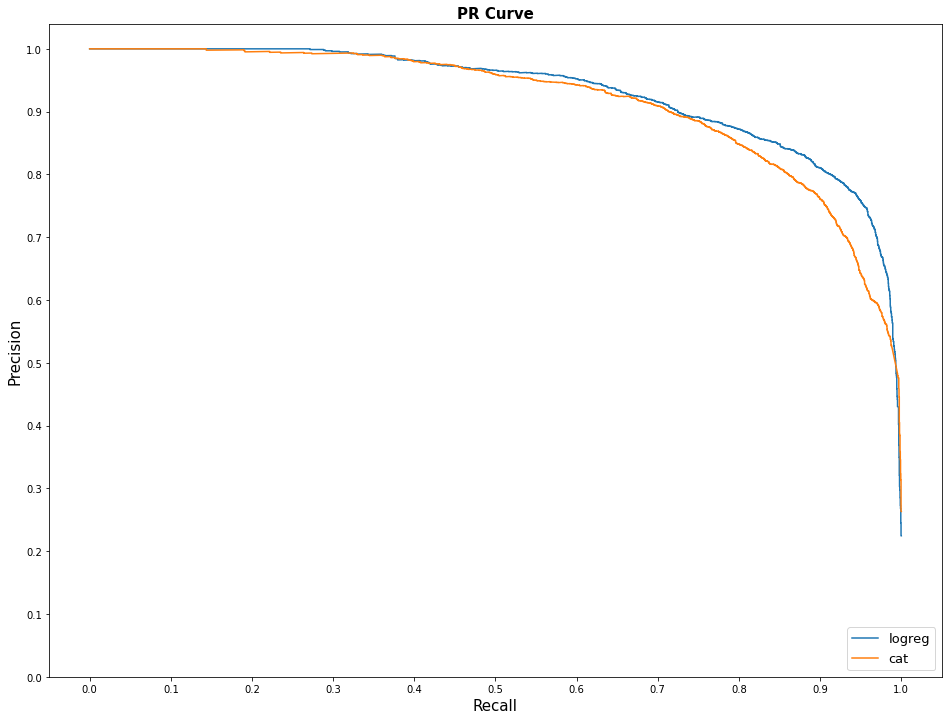

In [ ]:
fig = plt.figure(figsize=(16,12))

plt.plot(rc_logreg, pr_logreg,  label='logreg')
#plt.plot(rc_tree, pr_tree,  label='tree')
#plt.plot(rc_forest, pr_forest, label='forest') 
plt.plot(rc_modelcat, pr_modelcat,  label='cat') 

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("Recall", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("Precision", fontsize=15)

plt.title('PR Curve', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()

Видно, что логистическая регрессия отработала лучше, чем Catboost. При этом она в разы быстрыее. 

## Выводы

В ходе данного проекта было построено несколько моделей для классификации комментариев интернет-магазина "Викишоп" на позитивные и негативные. 

Заданному условию(метрика качества > 0.75) удовлетворили 2 модели - логистическая регрессия и Catboost. Из них у первой метрика F1 на несколько десятых выше и обучается она в разы быстрее, вследствие чего рекомендую к дальнейшему применению логистическую регрессию. 

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Модели обучены
- [x]  Значение метрики *F1* не меньше 0.75
- [x]  Выводы написаны